In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import os
from sklearn.utils.class_weight import compute_class_weight

sns.set_context('notebook')
sns.set_style('white')

In [2]:
classes = ['NORMAL', 'PNEUMONIA']

IMG_HEIGHT, IMG_WIDTH = 150, 150
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
SEED = 42

train_dir = 'data/train'
test_dir = 'data/test'
val_dir = 'data/val'

#### EDA

Check for data imbalance

In [3]:
train_normal_num_files = len(list(Path(train_dir + '/' + classes[0]).glob('*.jpeg')))
train_pneumonia_num_files = len(list(Path(train_dir + '/' + classes[1]).glob('*.jpeg')))

<Axes: >

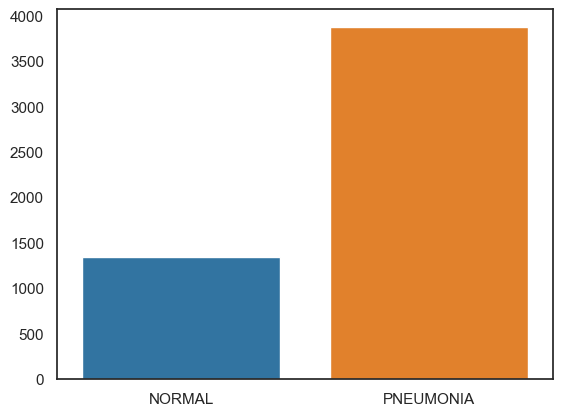

In [4]:
sns.barplot(
    x=classes,
    y=[train_normal_num_files, train_pneumonia_num_files],
    hue=classes
)

As we can see, there are almost 3 times more Pneumonia images than normal ones.

#### Load dataset

`image_dataset_from_directory` generates a tf.data.Dataset from image files in a directory.

If your directory structure is:

    main_directory/
    ...class_a/
    ......a_image_1.jpg
    ......a_image_2.jpg
    ...class_b/
    ......b_image_1.jpg
    ......b_image_2.jpg
Then calling image_dataset_from_directory(main_directory, labels='inferred') will return a tf.data.Dataset that yields batches of images from the subdirectories class_a and class_b, together with labels 0 and 1 (0 corresponding to class_a and 1 corresponding to class_b).

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    color_mode='rgb',
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode='rgb',
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    color_mode='rgb',
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


#### Augment data

##### Benefits of Using the tf.keras.layers Augmentation Layer

**1. On-the-fly augmentation during training**  
- Augmentations are applied dynamically during training, which means:
    - No extra disk space is needed for augmented images.
    - The model sees new variations every epoch, improving generalization.
- It helps simulate a larger, more diverse dataset without manual duplication.

**2. GPU-accelerated and built into the TensorFlow graph**
- These layers run as part of the TensorFlow computational graph, meaning:
    - They’re fast and optimized for GPUs/TPUs.
    - No slow, CPU-bound Python loops or I/O bottlenecks.
- Ideal for large-scale training pipelines.

In [6]:
# Use Keras layers as augmentations
# This is a simple augmentation pipeline that includes random flipping, rotation, zooming, and contrast adjustment.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])  

def augment(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]
    image = data_augmentation(image)
    return image, label

def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize the image to [0, 1]
    return image, label

# Apply the augmentation to the training dataset
train_ds = train_ds.map(augment, num_parallel_calls=AUTOTUNE)

# Normalize the validation and test datasets
val_ds = val_ds.map(normalize, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(normalize, num_parallel_calls=AUTOTUNE)


#### Prefetch data for performance

`prefetch()` allows the data loading and model training to run in parallel.

Without prefetching, the workflow looks like this — sequential and slower:

- Load a batch of data
- Train on that batch
- Load the next batch
- Train again
(Repeat...)

This means the GPU waits while the CPU loads data — wasted time!

With `prefetch(buffer_size=N)`, TensorFlow starts loading the next N batches in the background while the model is training on the current batch.
So the steps overlap like this:

- While training on batch A, the pipeline is loading batch B
- When batch A is done, batch B is ready instantly  

`tf.data.AUTOTUNE` lets TensorFlow decide the optimal buffer size dynamically.






In [7]:
# Prefetch for performance
# This allows later batches to be prepared while the current one is being processed
# This will speed up training
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

#### Compute Class Weights

**Why Use Class Weights?**  
When the dataset is imbalanced (e.g., many more "Normal" than "Pneumonia" X-rays), the model can get high accuracy by just predicting the majority class all the time.

Imagine this:
- 90% Normal
- 10% Pneumonia

A model that always predicts "Normal" would have 90% accuracy, but 0% recall for Pneumonia — which is unacceptable in medical diagnostics.

So, to combat this imbalance, class weights adjust the importance of each class when calculating the loss.

**What Do Class Weights Do, Mathematically?**  
In a standard loss like binary cross-entropy, each example contributes equally. But with class weights, the contribution to the loss is scaled:

Binary Cross-Entropy (with weights):  
Loss = −𝑤1 ⋅ 𝑦 ⋅ log(𝑦^) − 𝑤0 ⋅ (1 − 𝑦) ⋅ log(1 − 𝑦^)

Where:
- 𝑦 is the true label
- 𝑦^ is the predicted probability
- 𝑤1, 𝑤0 are weights for class 1 and 0, respectively

This makes mistakes on minority class samples "hurt more" in training, nudging the model to learn their features better.

In [8]:
# Get all training labels
y_train = np.concatenate([y for x, y in train_ds], axis=0)

class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)

class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)


Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [9]:
vgg = vgg16.VGG16(include_top=False,
                        weights='imagenet',
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

output = vgg.output
output = tf.keras.layers.Flatten()(output)

basemodel = Model(vgg.input, output)
# basemodel.trainable = False
# for layer in basemodel.layers: layer.trainable = False 
basemodel.trainable = True
for layer in basemodel.layers[:-4]:  # Fine-tune last few layers
    layer.trainable = False

input_shape = basemodel.output_shape[1]
model = Sequential()
model.add(basemodel)
model.add(Dense(128, activation='relu', input_dim=input_shape))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8192)              14714688  
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 15,763,521
Trainable params: 5,768,449
Non-trainable params: 9,995,072
_________________________________________________________________


In [10]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy', 
                       tf.keras.metrics.AUC(name='auc'), 
                    #    tf.keras.metrics.Precision(name='precision'), 
                    #    tf.keras.metrics.Recall(name='recall')
                       ])

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', # You can also use 'val_auc' or 'val_accuracy'
                               patience=4, # Wait n epochs before stopping if no improvement
                               verbose=1,
                               restore_best_weights=True)

In [12]:
# Fit the model
history = model.fit(train_ds, 
                    epochs=10,
                    validation_data=val_ds,
                    class_weight=class_weight_dict,
                    callbacks=[early_stopping],
                    batch_size=BATCH_SIZE,)  

Epoch 1/10
326/326 [==============================] - 29s 65ms/step - loss: 0.2163 - accuracy: 0.9087 - auc: 0.9769 - val_loss: 0.1459 - val_accuracy: 0.9375 - val_auc: 1.0000
Epoch 2/10
326/326 [==============================] - 21s 64ms/step - loss: 0.0997 - accuracy: 0.9613 - auc: 0.9938 - val_loss: 0.1187 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 3/10
326/326 [==============================] - 21s 64ms/step - loss: 0.0885 - accuracy: 0.9641 - auc: 0.9951 - val_loss: 0.1148 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 4/10
326/326 [==============================] - 21s 64ms/step - loss: 0.0736 - accuracy: 0.9724 - auc: 0.9965 - val_loss: 0.1548 - val_accuracy: 0.9375 - val_auc: 1.0000
Epoch 5/10
326/326 [==============================] - 21s 64ms/step - loss: 0.0682 - accuracy: 0.9745 - auc: 0.9969 - val_loss: 0.1105 - val_accuracy: 1.0000 - val_auc: 1.0000
Epoch 6/10
326/326 [==============================] - 21s 65ms/step - loss: 0.0613 - accuracy: 0.9772 - auc: 0.9974 - va

In [13]:
model.evaluate(test_ds)

39/39 [==============================] - 2s 51ms/step - loss: 0.3406 - accuracy: 0.9038 - auc: 0.9587


[0.3406071364879608, 0.9038461446762085, 0.9586948156356812]

#### Show Misclassifications

In [18]:
y_true = []
y_pred = []
images = []

for batch_images, batch_labels in test_ds:
    preds = model.predict(batch_images)
    y_true.extend(batch_labels.numpy())
    y_pred.extend((preds > 0.5).astype(int).flatten())
    images.extend(batch_images.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)   
images = np.array(images)


1/1 [==============================] - 0s 23ms/step


In [23]:
misclassified_idxs = np.where(y_true != y_pred)[0]  # Get the indices of misclassified images
print(f"Total misclassified images: {len(misclassified_idxs)}")

Total misclassified images: 60


In [39]:
normal_misclassified = np.sum(y_true[misclassified_idxs] == 0)
pneumonia_misclassified = np.sum(y_true[misclassified_idxs] == 1)
print(f"Normal misclassified: {normal_misclassified}")
print(f"Pneumonia misclassified: {pneumonia_misclassified}")

Normal misclassified: 55
Pneumonia misclassified: 5
